# ResNeXt [7 points]
Based on your ResNet implementation in Part I, extend it to ResNeXT. It is expected that your accuracy is higher than ResNet. Compare the results with your VGG and ResNet implementation.

In [33]:
import os
import time
import random
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [20]:
%matplotlib inline

In [2]:
#Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
torch.cuda.is_available() 

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Step 1: Implement the ResNeXT architecture
Pay close attention to the grouped convolutions and cardinality parameter. Using inbuild ResNeXt model won’t be considered for evaluation.

In [5]:
class ResNeXt_Bot(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, cardinality=32, base_width=4, downsample=None, init_method='he'):
        super(ResNeXt_Bot, self).__init__()
        D = int(math.floor(out_channels * (base_width / 64.0))) * cardinality
        self.conv1 = nn.Conv2d(in_channels, D, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(D)
        self.conv2 = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(D)
        self.conv3 = nn.Conv2d(D, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init_method == 'he':
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif init_method == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [6]:
#Using the similar structure of my previous best model of resnet
class ResNeXt(nn.Module):
    def __init__(self, block, layers, num_classes=3, cardinality=32, base_width=4, init_method='he'):
        super(ResNeXt, self).__init__()
        self.in_channels = 64
        self.init_method = init_method
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1, cardinality=cardinality, base_width=base_width)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, cardinality=cardinality, base_width=base_width)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, cardinality=cardinality, base_width=base_width)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, cardinality=cardinality, base_width=base_width)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init_method == 'he':
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif init_method == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                if init_method == 'he':
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif init_method == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride, cardinality, base_width):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, cardinality, base_width, downsample, init_method=self.init_method))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, 1, cardinality, base_width, init_method=self.init_method))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnext50(num_classes=3, cardinality=32, base_width=4, init_method='he'):
    return ResNeXt(ResNeXt_Bot, [3, 4, 6, 3], num_classes=num_classes, cardinality=cardinality, base_width=base_width, init_method=init_method)


In [7]:
#Helps take the optimizer for init
def get_optimizer(model, optimizer_name, lr):
    if optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
        
#Define similar helper functions as in part 1
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
            return self.early_stop        
        
        
def get_transforms(use_data_aug=False):
    if use_data_aug:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform        
        
        
def get_data_loaders(dataset_dir, batch_size, use_data_aug=False):
    train_transform, test_transform = get_transforms(use_data_aug)
    full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)
    indices = np.arange(len(full_dataset))
    train_idx, test_val_idx = train_test_split(indices, test_size=0.2, stratify=full_dataset.targets, random_state=42)
    val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5,
                                         stratify=[full_dataset.targets[i] for i in test_val_idx], random_state=42)
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset_full = datasets.ImageFolder(root=dataset_dir, transform=test_transform)
    test_dataset_full = datasets.ImageFolder(root=dataset_dir, transform=test_transform)
    val_dataset = Subset(val_dataset_full, val_idx)
    test_dataset = Subset(test_dataset_full, test_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader

#Train & eval the model
def train_and_evaluate(model, train_loader, val_loader, test_loader, device, config, exp_id):
    writer = SummaryWriter(log_dir=f"runs/exp_{exp_id}_{time.strftime('%Y%m%d-%H%M%S')}")
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, config['optimizer'], config['learning_rate'])
    scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=config['lr_gamma'], 
    patience=config.get('lr_scheduler_patience', 5), 
    verbose=True
    )
    
    early_stopping = EarlyStopping(patience=config['patience'], verbose=True)
    
    model = model.to(device)
    best_model_wts = None
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            if config.get("mixup", False):
                mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=config.get("mixup_alpha", 1.0))
                outputs = model(mixed_inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        
        #Val phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Accuracy/Val", val_acc, epoch)
        
        print(f"Exp {exp_id} | Epoch {epoch+1}/{config['num_epochs']} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            save_path = f"{exp_id}.pth"
            torch.save(best_model_wts, save_path)
            
        if early_stopping(val_loss, model):
            print("Early stopping triggered.")
            break
        
    
    writer.close()
    
    #Eval phase
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    test_all_preds = []
    test_all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            test_all_preds.extend(preds.cpu().numpy())
            test_all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    test_cm = confusion_matrix(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')
    print(f"\nExp {exp_id} Test Evaluation:")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Confusion Matrix:\n{test_cm}")
    print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
    
    return {
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'test_cm': test_cm,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }

#Data regularization technique used (mixup)
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Step 2: Train and evaluate your ResNeXt model
Train and evaluate your ResNeXt model on the same dataset used in Part I.

In [10]:
config = {
        'num_epochs': 35,
        'learning_rate': 0.005312607974064016,
        'lr_step': 10,
        'lr_gamma': 0.1,
        'dataset_dir': 'cnn_dataset',  
        'optimizer': 'adam',
        'init_method': 'he',
        'batch_size': 32,
        'patience': 10,
        'mixup': True,         
        'mixup_alpha': 0.7     
    }
    

train_loader, val_loader, test_loader = get_data_loaders(config['dataset_dir'], config['batch_size'])

model = resnext50(num_classes=3, cardinality=32, base_width=4, init_method=config['init_method'])

exp_id = "ResNeXt_ES_Mixup"
results = train_and_evaluate(model, train_loader, val_loader, test_loader, device, config, exp_id)

print(f"\nFinal Test Accuracy for ResNeXt: {results['test_acc']:.4f}")

Exp ResNeXt_ES_Mixup | Epoch 1/35 - Train Loss: 0.8921, Train Acc: 0.5573, Val Loss: 0.5150, Val Acc: 0.8180
Exp ResNeXt_ES_Mixup | Epoch 2/35 - Train Loss: 0.6915, Train Acc: 0.5966, Val Loss: 0.4077, Val Acc: 0.8703
Exp ResNeXt_ES_Mixup | Epoch 3/35 - Train Loss: 0.6433, Train Acc: 0.6147, Val Loss: 0.3703, Val Acc: 0.8963
Exp ResNeXt_ES_Mixup | Epoch 4/35 - Train Loss: 0.6233, Train Acc: 0.6144, Val Loss: 0.3832, Val Acc: 0.8720
EarlyStopping counter: 1 out of 10
Exp ResNeXt_ES_Mixup | Epoch 5/35 - Train Loss: 0.6096, Train Acc: 0.6249, Val Loss: 0.2925, Val Acc: 0.9107
Exp ResNeXt_ES_Mixup | Epoch 6/35 - Train Loss: 0.5857, Train Acc: 0.6191, Val Loss: 0.3071, Val Acc: 0.9127
EarlyStopping counter: 1 out of 10
Exp ResNeXt_ES_Mixup | Epoch 7/35 - Train Loss: 0.5802, Train Acc: 0.6311, Val Loss: 0.4169, Val Acc: 0.8657
EarlyStopping counter: 2 out of 10
Exp ResNeXt_ES_Mixup | Epoch 8/35 - Train Loss: 0.5650, Train Acc: 0.6551, Val Loss: 0.2411, Val Acc: 0.9327
Exp ResNeXt_ES_Mixup | 

In [24]:
history = results['history']

## Step 3: Compare the performance of your ResNeXt model
Compare the performance of your ResNeXt model against your previous ResNet and VGG models. Provide a detailed analysis of the results.

In [13]:
#Loading the train, test data of other models taken from our part1 of the project

#VGG
train_losses_vgg = [0.7755079404058911, 0.5064942116623833, 0.41907461838495164, 0.361461782909575, 0.31463205218315127, 0.2837349299788475, 0.2520964642649605, 0.23336114595617566, 0.2031063601516542, 0.1801866364308766]
train_accs_vgg = [0.6361904761904762, 0.8004761904761905, 0.8382857142857143, 0.8608095238095238, 0.8822380952380953, 0.8918095238095238, 0.9047142857142857, 0.9118095238095238, 0.923, 0.9343809523809524]
val_losses_vgg = [0.5076592330932617, 0.4269339513513777, 0.37907193125618827, 0.3163323191271888, 0.2964695050186581, 0.2784410022629632, 0.3436990509298113, 0.2579884813692835, 0.3171757252679931, 0.2584740707145797]
val_accs_vgg = [0.7993333333333333, 0.8266666666666667, 0.864, 0.8822222222222222, 0.8842222222222222, 0.8924444444444445, 0.8755555555555556, 0.9051111111111112, 0.8851111111111112, 0.904888888888889]
test_loss_vgg = 0.2468
test_acc_vgg = 0.9091

#Resnet
train_losses_res = [0.6814667278698513, 0.5743110807396117, 0.5504688636234828, 0.5141196505682809, 0.5025241153353737, 0.4892336047717503, 0.4908684737909408, 0.4539867091973623, 0.4585125615596771, 0.43787543687366304, 0.3975911409514291, 0.397602581347738]
train_accs_res = [0.573047619047619, 0.6126666666666667, 0.637095238095238, 0.6239523809523809, 0.6432857142857142, 0.641095238095238, 0.6574761904761904, 0.6531428571428571, 0.6496666666666666, 0.6504761904761904, 0.6735714285714286, 0.6450476190476191]
val_losses_res = [0.44454012192620174, 0.36356124716334876, 0.2815040718317032, 0.2537566509114371, 0.23151912132898966, 0.25916093368000453, 0.2872505743238661, 0.2159846739239163, 0.2539200418525272, 0.22453344265619915, 0.16899959054258135, 0.18179676936732397]
val_accs_res = [0.856, 0.8755555555555555, 0.9011111111111111, 0.924, 0.9235555555555556, 0.9164444444444444, 0.9331111111111111, 0.9364444444444444, 0.9122222222222223, 0.9357777777777778, 0.9573333333333334, 0.9553333333333334]
test_loss_res = 0.1747
test_acc_res = 0.9609

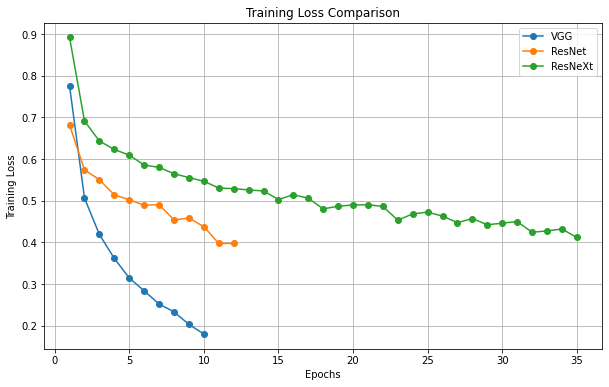

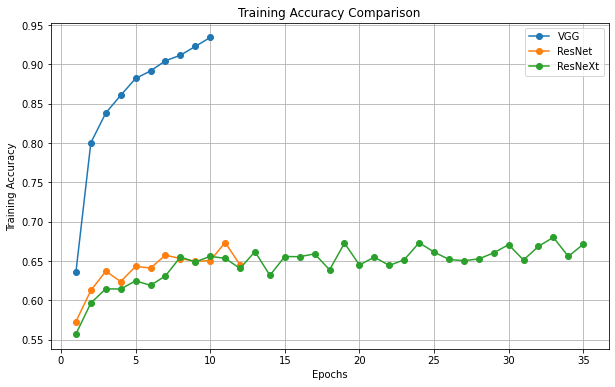

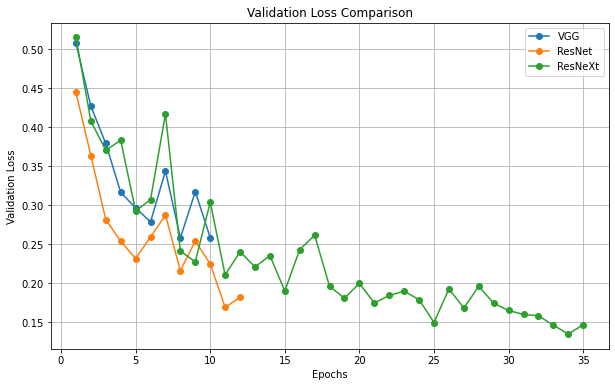

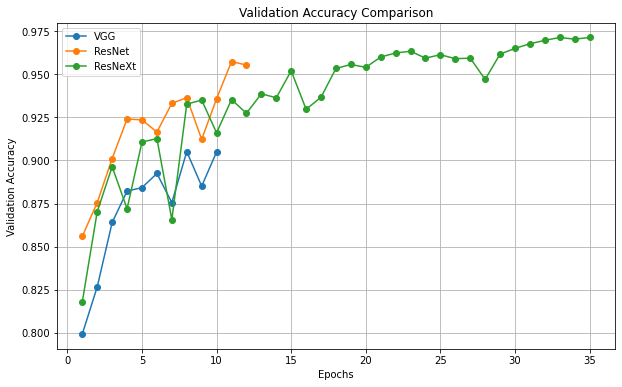

In [21]:
#Comparision plots to better analyze the models performance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_vgg)+1), train_losses_vgg, label='VGG', marker='o')
plt.plot(range(1, len(train_losses_res)+1), train_losses_res, label='ResNet', marker='o')
plt.plot(range(1, len(history['train_loss'])+1), history['train_loss'], label='ResNeXt', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs_vgg)+1), train_accs_vgg, label='VGG', marker='o')
plt.plot(range(1, len(train_accs_res)+1), train_accs_res, label='ResNet', marker='o')
plt.plot(range(1, len(history['train_acc'])+1), history['train_acc'], label='ResNeXt', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_losses_vgg)+1), val_losses_vgg, label='VGG', marker='o')
plt.plot(range(1, len(val_losses_res)+1), val_losses_res, label='ResNet', marker='o')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='ResNeXt', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accs_vgg)+1), val_accs_vgg, label='VGG', marker='o')
plt.plot(range(1, len(val_accs_res)+1), val_accs_res, label='ResNet', marker='o')
plt.plot(range(1, len(history['val_acc'])+1), history['val_acc'], label='ResNeXt', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

As discussed in our part 1 of the project, there is huge difference between the train losses and accuracies to the validation and test ones in ResNet & ResNeXt models, this is soley because of the implementation of mixup regularization method, making it difficult to compare. Also, there is a epoch difference between each models as some models require higher number of epochs to learn better.

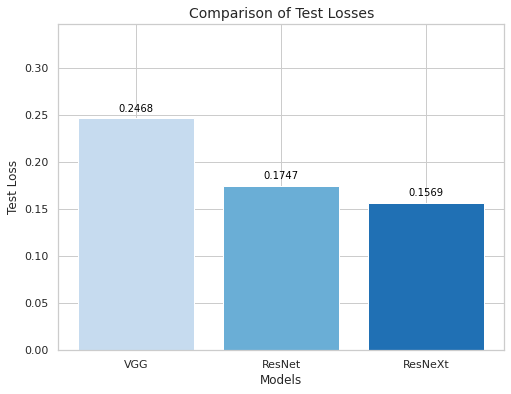

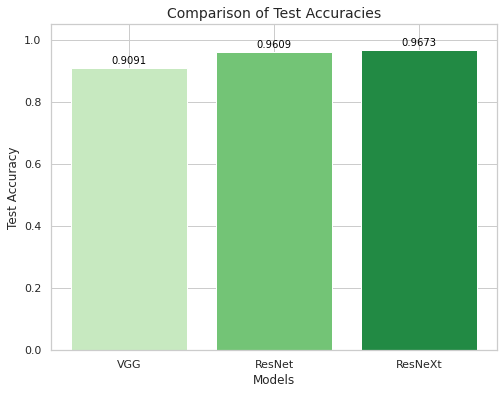

In [31]:
models = ['VGG', 'ResNet', 'ResNeXt']
test_losses = [test_loss_vgg, test_loss_res, results['test_loss']]
test_accuracies = [test_acc_vgg, test_acc_res, results['test_acc']]

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
bars = plt.bar(models, test_losses, color=sns.color_palette("Blues", n_colors=3))
plt.xlabel('Models', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Comparison of Test Losses', fontsize=14)
plt.ylim(0, max(test_losses) + 0.1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.4f}", ha='center', va='bottom', fontsize=10, color='black')

plt.show()

plt.figure(figsize=(8, 6))
bars = plt.bar(models, test_accuracies, color=sns.color_palette("Greens", n_colors=3))
plt.xlabel('Models', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Comparison of Test Accuracies', fontsize=14)
plt.ylim(0, 1.05)  

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.4f}", ha='center', va='bottom', fontsize=10, color='black')
plt.show()

### a. A table summarizing the performance metrics (accuracy, loss, etc.) for all three models.

In [42]:
#Creating a summary of test metrics comparing all models
data = {
    'Model': ['VGG', 'ResNet', 'ResNeXt'],
    'Test Loss': [test_loss_vgg, test_loss_res, results['test_loss']],
    'Test Accuracy': [test_acc_vgg, test_acc_res, results['test_acc']]
}
df_summary = pd.DataFrame(data)
df_summary['Test Loss'] = df_summary['Test Loss'].round(4)
df_summary['Test Accuracy'] = df_summary['Test Accuracy'].round(4)

print("\nSummary of Test Metrics:\n")
print(df_summary.to_string(index=False))


Summary of Test Metrics:

  Model  Test Loss  Test Accuracy
    VGG     0.2468         0.9091
 ResNet     0.1747         0.9609
ResNeXt     0.1569         0.9673


### b. Discussion of the observed differences in performance.
Explain why ResNeXt might be outperforming ResNet and VGG. Consider factors like cardinality, grouped convolutions, and the overall architecture.

### `Performance Observations:`
- ResNeXt outperforms VGG and ResNet. The improvement is evident in the final test statistics as well as in the training and validation plots. 
- The ResNeXt training plots show steady decrease in loss and rise in accuracy over more epochs, suggesting that the model was being assisted by the architectural design. 

### `Why ResNeXt outperformed:`
- ResNeXt proposes the concept of "cardinality" which is actually the amount of independent paths within a layer. This allows the model to be able to learn more diverse features. 
- Grouped convolutions are used, decreasing the computational expense while enhancing the expressiveness of the network. This design gives a more balanced relationship between performance and model complexity. 
- In contrast to ResNet, which requires residual connections to simplify the training of deep networks, ResNeXt applies a number of transformations in parallel to better represent features. 


### c. Analysis of any challenges encountered during the implementation or training process.

### `Challenges Encountered:` 
- Differences in the number of training epochs within each model may render comparison difficulty. However, test metrics at the conclusion are a good enough place to start with to quantify performance as a whole. 
- Hyperparameter optimization for each architecture can be challenging since each network could react differently than regularization methods and learning rate schedules. 
- Grouped convolutions are hard to code, especially when guaranteeing that computational efficiency is not compromised at the cost of performance.
- Also, the ResNet model itself gave the best accuracy around 96%, which made it hard for the ResNeXt to outperform in a larger scale.
- But given the constraints, going from 85-95% is much easier than the jump of 96 to ~97 as the model might start overfitting the data.

### d. Provide detailed analysis of the results.

### `Analysis:`

- **VGG:** VGG performs well but has higher maximum training loss and lower accuracy on the test and validation sets compared to ResNet and ResNeXt. It gets a test accuracy of 90.91%, which is also excellent, but could be improved if compared to ResNet and ResNeXt. 

- **ResNet:** The ResNet model performs well with reduced test loss (0.1747) and a 96.09% test accuracy. The model appears to have learned suitably, and the structure helps with vanishing gradients, which can be beneficial in its stable performance. 

- **ResNeXt:** Contrary to expectations, ResNeXt is better than both ResNet and VGG on test accuracy (96.73%) and test loss (0.1569). This can be attributed to the architectural enhancements over ResNet, including cardinality (higher number of feature maps per block), which allows the model to learn more complex patterns.

Briefly, the jump from 96 to ~97% from resNet to ResNeXt is actually 10-15% performance increase compared to other models. In spite of the difficulty in matching training outcomes between models, the outcomes demonstrate that the ResNeXt architecture has a desirable advantage over traditional models like VGG and even ResNet.

### 4.	References

#### 1. **ResNeXt (Aggregated Residual Transformation for Deep Neural Networks)**
 - Xie, S., Girshick, R., Dollár, P., Yu, Z., & He, K. (2017). *Aggregated Residual Transformations for Deep Neural Networks.* IEEE Conference on Computer Vision and Pattern Recognition (CVPR). [https://arxiv.org/abs/1611.05431](https://arxiv.org/abs/1611.05431)


#### 2. **General Deep Learning Techniques**
 - Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning.* MIT Press. [http://www.deeplearningbook.org/](http://www.deeplearningbook.org/)


#### 3. **Deep Learning with PyTorch**
 - Paszke, A., et al. (2019). *PyTorch: An Imperative Style, High-Performance Deep Learning Library.* Advances in Neural Information Processing Systems (NeurIPS). [https://arxiv.org/abs/1912.01703](https://arxiv.org/abs/1912.01703)

